# Agentic Metric - Evaluación de Conversaciones Completas

Este notebook demuestra cómo usar la métrica **Agentic** de Fair Forge para evaluar agentes conversacionales.

## Qué Evalúa

La métrica evalúa **conversaciones completas**. Una conversación es correcta solo si **TODAS** sus interacciones son correctas.

- **pass@K**: Probabilidad de ≥1 conversación correcta en K intentos
- **pass^K**: Probabilidad de K conversaciones correctas consecutivas
- **Tool Correctness**: Evaluación del uso de herramientas (opcional)

## Fórmulas

```
pass@k = 1 - C(n-c, k) / C(n, k)   # Prob. de ≥1 correcta
pass^k = (c/n)^k                    # Prob. de todas correctas
```

Donde:
- **n** = total de conversaciones evaluadas
- **c** = conversaciones completamente correctas
- **k** = número de intentos (elegido por el usuario)

## Instalación

Instala Fair Forge con soporte agentic:

In [ ]:
!pip install alquimia-fair-forge[agentic] langchain-groq

## Setup

Importa los módulos necesarios:

In [1]:
import json
from pathlib import Path

from langchain_groq import ChatGroq

from fair_forge import Retriever
from fair_forge.metrics.agentic import Agentic
from fair_forge.schemas import Batch, Dataset

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


## API Key

Configura tu API key de Groq:

In [2]:
import getpass

GROQ_API_KEY = getpass.getpass("Enter your Groq API key: ")

## Crear Retriever

El Retriever carga **conversaciones completas**. Cada `Dataset` representa una conversación con múltiples interacciones:

In [ ]:
class ConversationRetriever(Retriever):
    """Retriever que carga conversaciones completas."""

    def load_dataset(self) -> list[Dataset]:
        # Cargar desde JSON si existe, sino usar datos de ejemplo
        dataset_path = Path("dataset_agentic.json")
        
        if dataset_path.exists():
            with open(dataset_path) as f:
                return [Dataset.model_validate(data) for data in json.load(f)]
        
        # Datos de ejemplo: 3 conversaciones
        print("⚠️  No se encontró dataset_agentic.json, usando datos de ejemplo")
        return [
            # Conversación 1: Completamente correcta (3/3)
            Dataset(
                session_id="conversation_001",
                assistant_id="agent_v1",
                language="spanish",
                context="Conversación de preguntas y respuestas",
                conversation=[
                    Batch(
                        qa_id="qa_001_1",
                        query="¿Cuál es la capital de Francia?",
                        assistant="La capital de Francia es París.",
                        ground_truth_assistant="París",
                    ),
                    Batch(
                        qa_id="qa_001_2",
                        query="¿Cuánto es 5 + 7?",
                        assistant="5 más 7 es igual a 12.",
                        ground_truth_assistant="12",
                    ),
                    Batch(
                        qa_id="qa_001_3",
                        query="¿Cuánto es 10 * 3?",
                        assistant="10 por 3 es 30.",
                        ground_truth_assistant="30",
                    ),
                ],
            ),
            # Conversación 2: Completamente correcta (2/2)
            Dataset(
                session_id="conversation_002",
                assistant_id="agent_v1",
                language="spanish",
                context="Conversación simple",
                conversation=[
                    Batch(
                        qa_id="qa_002_1",
                        query="¿Cuánto es 8 + 9?",
                        assistant="8 más 9 es 17.",
                        ground_truth_assistant="17",
                    ),
                    Batch(
                        qa_id="qa_002_2",
                        query="¿Cuál es el color del cielo?",
                        assistant="El cielo es azul.",
                        ground_truth_assistant="azul",
                    ),
                ],
            ),
            # Conversación 3: Parcialmente correcta (1/3 - FAIL)
            Dataset(
                session_id="conversation_003",
                assistant_id="agent_v1",
                language="spanish",
                context="Conversación con errores",
                conversation=[
                    Batch(
                        qa_id="qa_003_1",
                        query="¿Cuánto es 16 / 2?",
                        assistant="16 dividido 2 es 8.",
                        ground_truth_assistant="8",
                    ),
                    Batch(
                        qa_id="qa_003_2",
                        query="¿Cuánto es 5 * 5?",
                        assistant="5 por 5 es 20.",  # INCORRECTO
                        ground_truth_assistant="25",
                    ),
                    Batch(
                        qa_id="qa_003_3",
                        query="¿Cuánto es 100 / 4?",
                        assistant="100 dividido 4 es 20.",  # INCORRECTO
                        ground_truth_assistant="25",
                    ),
                ],
            ),
        ]

## Vista Previa del Dataset

In [4]:
retriever = ConversationRetriever()
datasets = retriever.load_dataset()

print(f"Total conversaciones: {len(datasets)}\n")
for i, ds in enumerate(datasets, 1):
    print(f"{i}. {ds.session_id}: {len(ds.conversation)} interacciones")

Total conversaciones: 3

1. arsat_connectivity_flow_001: 3 interacciones
2. arsat_connectivity_flow_001: 3 interacciones
3. arsat_connectivity_flow_001: 3 interacciones


## Inicializar Judge Model

El modelo LLM actúa como judge para evaluar respuestas:

In [5]:
judge_model = ChatGroq(
    model="llama-3.3-70b-versatile",
    api_key=GROQ_API_KEY,
    temperature=0.0,
)

## Ejecutar Evaluación

La métrica evalúa cada conversación completa:

In [6]:
metrics = Agentic.run(
    ConversationRetriever,
    model=judge_model,
    threshold=0.7,
    tool_threshold=0.75,
    verbose=True,
)

print(f"\n✅ Evaluación completada. Conversaciones evaluadas: {len(metrics)}")

2026-02-16 14:01:13,467 - fair_forge.utils.logging - INFO - Loaded dataset with 3 batches
2026-02-16 14:01:13,469 - fair_forge.utils.logging - INFO - Initialized Agentic metric with model: ChatGroq
2026-02-16 14:01:13,470 - fair_forge.utils.logging - INFO - Thresholds - Answer: 0.7, Tool: 0.75
2026-02-16 14:01:13,470 - fair_forge.utils.logging - INFO - [Agentic] Evaluating 3 conversations
2026-02-16 14:01:13,471 - fair_forge.utils.logging - INFO - [Agentic] Evaluating conversation 1/3: arsat_connectivity_flow_001 (3 interactions)
2026-02-16 14:01:13,472 - fair_forge.utils.logging - DEBUG -   Interaction 1/3 (qa_id: connectivity_001_report_issue)
2026-02-16 14:01:14,258 - httpx - INFO - HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
2026-02-16 14:01:14,270 - fair_forge.utils.logging - DEBUG - Judge returned - reasoning: None...
2026-02-16 14:01:14,271 - fair_forge.utils.logging - DEBUG - ✓ Judge result type: <class 'fair_forge.metrics.agentic.Answer


✅ Evaluación completada. Conversaciones evaluadas: 3


## Resultados por Conversación

In [7]:
print("=" * 80)
print("RESULTADOS POR CONVERSACIÓN")
print("=" * 80)

for i, metric in enumerate(metrics, 1):
    status = "✅" if metric.is_fully_correct else "❌"
    print(f"\n{i}. {metric.session_id}")
    print(f"   Interacciones: {metric.correct_interactions}/{metric.total_interactions}")
    print(f"   Estado: {status} {'CORRECTA' if metric.is_fully_correct else 'INCORRECTA'}")

# Resumen
fully_correct = sum(1 for m in metrics if m.is_fully_correct)
print(f"\n{'-' * 80}")
print(f"Conversaciones correctas: {fully_correct}/{len(metrics)} ({fully_correct/len(metrics):.1%})")
print("=" * 80)

RESULTADOS POR CONVERSACIÓN

1. arsat_connectivity_flow_001
   Interacciones: 3/3
   Estado: ✅ CORRECTA

2. arsat_connectivity_flow_001
   Interacciones: 1/3
   Estado: ❌ INCORRECTA

3. arsat_connectivity_flow_001
   Interacciones: 1/3
   Estado: ❌ INCORRECTA

--------------------------------------------------------------------------------
Conversaciones correctas: 1/3 (33.3%)


## Métricas Agregadas: pass@K y pass^K

**¿Qué significan?**
- **pass@K**: Probabilidad de ≥1 conversación correcta en K intentos
- **pass^K**: Probabilidad de que TODAS las K conversaciones sean correctas

**Tú eliges K** según tu caso de uso (K=1, 3, 5, etc.)

In [8]:
# ========================================
# 👤 CONFIGURA TU K AQUÍ
# ========================================
K = 2  # ← Cambia este número

agg = Agentic.aggregate_metrics(metrics, k=K)

print("=" * 80)
print(f"MÉTRICAS AGREGADAS (K={K})")
print("=" * 80)
print(f"\nConversaciones evaluadas (n): {agg['total_conversations']}")
print(f"Conversaciones correctas (c): {agg['fully_correct_conversations']}")
print(f"Tasa de éxito: {agg['conversation_success_rate']:.1%}")
print(f"\npass@{K}: {agg['pass_at_k']:.4f} ({agg['pass_at_k']*100:.1f}%)")
print(f"  → Prob. de ≥1 correcta en {K} intentos")
print(f"\npass^{K}: {agg['pass_pow_k']:.4f} ({agg['pass_pow_k']*100:.1f}%)")
print(f"  → Prob. de que las {K} sean correctas")

# Clasificación
if agg['pass_at_k'] > 0.95 and agg['pass_pow_k'] > 0.7:
    clasificacion = "✅ CONFIABLE"
elif agg['pass_at_k'] > 0.95 and agg['pass_pow_k'] < 0.5:
    clasificacion = "⚠️  INCONSISTENTE"
elif agg['pass_at_k'] > 0.7:
    clasificacion = "🔶 FUNCIONAL"
else:
    clasificacion = "❌ NECESITA MEJORA"

print(f"\n🎯 Clasificación: {clasificacion}")
print("=" * 80)

MÉTRICAS AGREGADAS (K=2)

Conversaciones evaluadas (n): 3
Conversaciones correctas (c): 1
Tasa de éxito: 33.3%

pass@2: 0.6667 (66.7%)
  → Prob. de ≥1 correcta en 2 intentos

pass^2: 0.1111 (11.1%)
  → Prob. de que las 2 sean correctas

🎯 Clasificación: ❌ NECESITA MEJORA


## Comparar Diferentes K (Opcional)

In [9]:
print("\nComparación con diferentes K:\n")
for k in [1, 2, 3]:
    if k > len(metrics):
        continue
    agg = Agentic.aggregate_metrics(metrics, k=k)
    print(f"K={k}: pass@{k}={agg['pass_at_k']:.3f}, pass^{k}={agg['pass_pow_k']:.3f}")


Comparación con diferentes K:

K=1: pass@1=0.333, pass^1=0.333
K=2: pass@2=0.667, pass^2=0.111
K=3: pass@3=1.000, pass^3=0.037


## Visualización

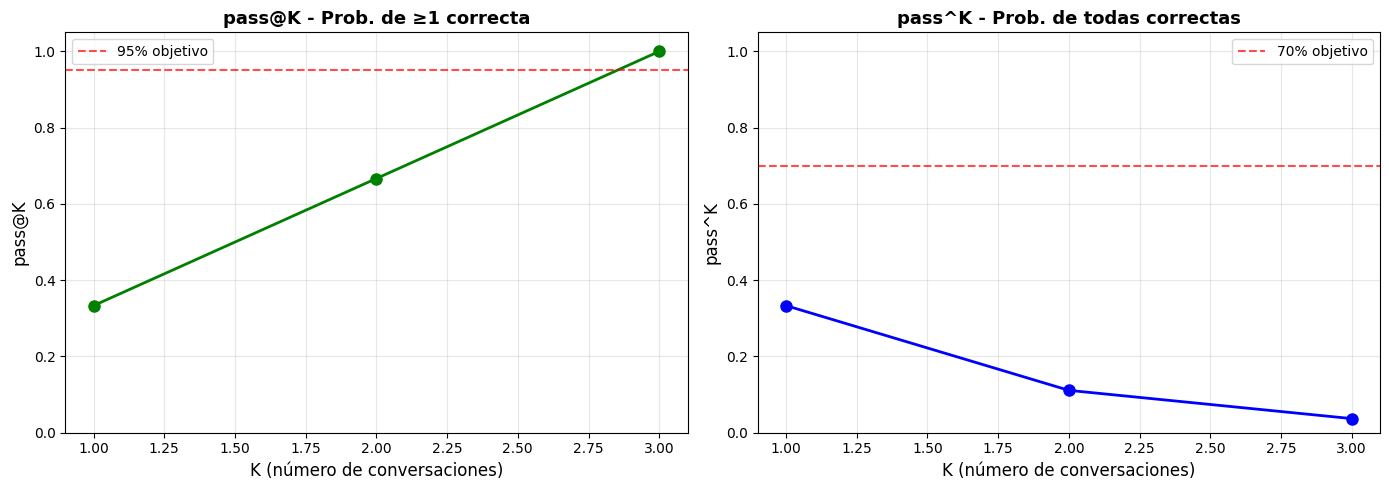

In [10]:
import matplotlib.pyplot as plt

# Calcular métricas para diferentes K
max_k = min(len(metrics), 10)
k_range = list(range(1, max_k + 1))
pass_at_k_values = []
pass_pow_k_values = []

for k in k_range:
    agg = Agentic.aggregate_metrics(metrics, k=k)
    pass_at_k_values.append(agg['pass_at_k'])
    pass_pow_k_values.append(agg['pass_pow_k'])

# Crear gráficas
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# pass@K
ax1.plot(k_range, pass_at_k_values, 'o-', color='green', linewidth=2, markersize=8)
ax1.axhline(y=0.95, color='red', linestyle='--', label='95% objetivo', alpha=0.7)
ax1.set_xlabel('K (número de conversaciones)', fontsize=12)
ax1.set_ylabel('pass@K', fontsize=12)
ax1.set_title('pass@K - Prob. de ≥1 correcta', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_ylim(0, 1.05)

# pass^K
ax2.plot(k_range, pass_pow_k_values, 'o-', color='blue', linewidth=2, markersize=8)
ax2.axhline(y=0.7, color='red', linestyle='--', label='70% objetivo', alpha=0.7)
ax2.set_xlabel('K (número de conversaciones)', fontsize=12)
ax2.set_ylabel('pass^K', fontsize=12)
ax2.set_title('pass^K - Prob. de todas correctas', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()
ax2.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()

## Interpretación

### Clasificación del Agente

| pass@K | pass^K | Clasificación |
|--------|--------|---------------|
| >95% | >70% | ✅ **CONFIABLE** |
| >95% | <50% | ⚠️ **INCONSISTENTE** |
| >70% | - | 🔶 **FUNCIONAL** |
| <70% | - | ❌ **NECESITA MEJORA** |

### Ejemplo Práctico

Si tienes **tasa de éxito del 60%** (6 de 10 conversaciones correctas):
- **K=1**: 60% de prob. de que una conversación sea correcta
- **K=3**: 93% de prob. de ≥1 correcta en 3 intentos
- **K=5**: 99% de prob. de ≥1 correcta en 5 intentos

**pass^K baja rápido**: Con K=5, solo 8% de prob. de que las 5 sean correctas.

## Personalización (Opcional)

Puedes ajustar umbrales y pesos:

## Conclusiones

### ✅ Aprendizajes Clave

1. **Conversación completa**: Una conversación es correcta solo si TODAS sus interacciones son correctas
2. **pass@K**: Mide la capacidad del agente (¿puede producir conversaciones correctas?)
3. **pass^K**: Mide la consistencia (¿qué tan consistente es?)
4. **K configurable**: El usuario elige K según su caso de uso

### 📚 Referencias

- [Fair Forge Docs](https://docs.alquimia.ai)
- [Paper: Evaluating Large Language Models Trained on Code](https://arxiv.org/abs/2107.03374)
- [GitHub](https://github.com/Alquimia-ai/fair-forge)